# Autoencoder Variacional en Generación de Imágenes
### Itzanami Berlanga Contreras | 12 de mayo del 2024

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Training data shapes: X=(10000, 28, 28)
Testing data shapes: X=(10000, 28, 28)


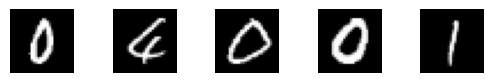

In [39]:
from tensorflow.keras.datasets import mnist
(trainX, _), (testX, _) = mnist.load_data()
trainX = trainX[0:10000]
testX = testX[0:10000]
print(f'Training data shapes: X={trainX.shape}')
print(f'Testing data shapes: X={testX.shape}')
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.axis("off")
plt.show()

In [40]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255
train_data = np.reshape(train_data, (10000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))
print (train_data.shape, test_data.shape)

(10000, 28, 28, 1) (10000, 28, 28, 1)


In [53]:
espacio_latente = 2

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Conv2D, Input, Lambda, Reshape, Conv2DTranspose, UpSampling2D

input_data = Input(shape=(28, 28, 1))
encoder = Conv2D(64, (5,5), activation='relu')(input_data)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(64, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(32, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Flatten()(encoder)
#encoder = Dense(16)(encoder)

In [43]:
tf.config.run_functions_eagerly(True)

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_mean)[0]
    dim = tf.shape(distribution_mean)[1]
    
    random = tf.keras.backend.random_normal(shape=(batch_size, dim))
    return distribution_mean + (tf.exp(0.5 * distribution_variance) * random)

In [55]:
distribution_mean = Dense(2, name='mean')(encoder)
distribution_variance = Dense(2, name='log_variance')(encoder)
latent_encoding = Lambda(sample_latent_features, output_shape = (espacio_latente,))([distribution_mean, distribution_variance])

In [56]:
encoder_model = tf.keras.Model(input_data, [distribution_mean, distribution_variance])
encoder_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 24, 24,    │      1,664 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 12, 12,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 10, 10,    │     36,928 │ max_pooling2d_27… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 5, 5, 64)  │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 3, 3, 32)  │     18,464 │ max_pooling2d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 1, 1, 32)  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         34 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_variance        │ (None, 2)         │         34 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,652 (225.20 KB)

 Trainable params: 57,652 (225.20 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
decoder_input = Input(shape=(espacio_latente,))
decoder = Dense(64)(decoder_input)
decoder = Reshape((1, 1, 64))(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder_output = Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [59]:
decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 5, 5, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 12, 12, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,577 (439.75 KB)

 Trainable params: 112,577 (439.75 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded[1])

In [63]:
autoencoder = tf.keras.models.Model(input_data, decoded)

In [76]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        # reconstruction_loss = tf.keras.losses.MSE(y_true, y_pred)
        reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

In [77]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ [(None, 2), (None, 2)] │        57,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 28, 28, 1)      │       112,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,229 (664.96 KB)

 Trainable params: 170,229 (664.96 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Epoch 1/20


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
    plt.axis("off")
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

In [ ]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

In [ ]:
generator_model = decoder_model
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

In [ ]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.axis('off')
plt.show()

## Referencias
- https://medium.com/vitrox-publication/generative-modeling-with-variational-auto-encoder-vae-fc449be9890e
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- 